## DSC 530 Data Exploration and Analysis 
* 5.2 Exercise: Modeling Distributions and PDFs

# Chapter 5

## Exercises

In [90]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [91]:
import numpy as np

import thinkstats2
import thinkplot

**Exercise 5-1:** In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

`scipy.stats` contains objects that represent analytic distributions

In [92]:
import scipy.stats

In [17]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
# Inlcuding the type function so I can better grasp what python is doing with the scipy package.
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

mu represent the mean of the distribution while sigma represents the standard deviation of the distribution

In [18]:
dist.mean(), dist.std() # Viewing as a tuple

(178.0, 7.7)

In [19]:
dist.cdf(178 - 7.7) # Since we assigned mu and sigma values to variable, the variables could have been used but it is easier 
# for me to learn by seeing what is happening. This is telling us that  about 16% of men fall 
# below one standard devaioiton from the mean.

0.1586552539314574

Must convert feet and inches to cm since mu and sigma are in cm

In [24]:
short = dist.cdf(177.8) # This is 5'10 converted to CM
tall = dist.cdf(185.4) # this is 6'1 converted to CM
short, tall, tall - short

(0.48963902786483265, 0.8317337108107857, 0.3420946829459531)

Based on the calcualtion above it appears that 34% of men fall between 5'10 and 6'1 or converting to cm to keep everything standards, we get that 34% of men fall between 177.8cm and 185.4cm. We also see that 49% of men fall within 177.8cm while 83% of men fall within 185.4cm

**Exercise 5-2:** To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [62]:
alpha = 1.7
xmin = 1  # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

1.5034066538560549

What is the mean height in Pareto world?

In [67]:
dist.mean() # Returns the mean height

2.428571428571429

What fraction of people are shorter than the mean?

In [76]:
dist.cdf(dist.mean()) # This returns the CDF of the mean, the plot below is actually a good representation of this. 

0.778739697565288

Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [78]:
(1 - dist.cdf(1000)) * 7e9 # We take the cdf of 1000 meters and multiply by 7e9 (7 billion)

55602.976430479954

How tall do we expect the tallest person to be?

In [84]:
dist.ppf(1 - 1 / 7e9) # I chose to use the percent point function for this.
# Per the book and examples the ppf is the inverse of the CDF

618349.6106759505

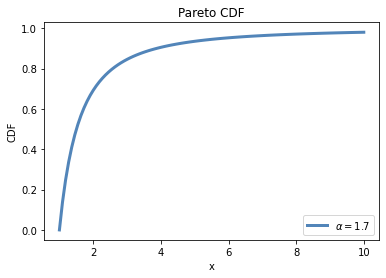

In [83]:
xmin = 1

thinkplot.PrePlot(1)
for alpha in [1.7]:
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100)
    thinkplot.Plot(xs, ps, label=r"$\alpha=%g$" % alpha)

thinkplot.Config(title="Pareto CDF", xlabel="x", ylabel="CDF", loc="lower right")

# Chapter 6

## Exercises

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [25]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample

In [29]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

Downloaded hinc.py
Downloaded hinc06.csv


In [37]:
import hinc
income_df = hinc.ReadData()

In [31]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

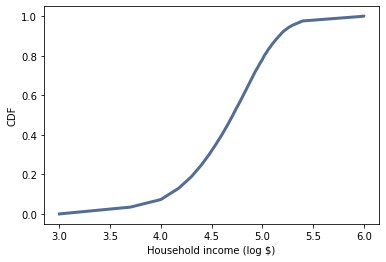

In [32]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [33]:
sample = np.power(10, log_sample)

The "sample" is using the numpy power function taking the array returned from InterpolateSample which is log_sample and 10.

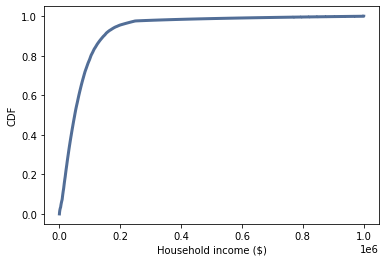

In [94]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [45]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

In [46]:
def Mean(xs):
    return RawMoment(xs, 1)

In [47]:
def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

In [48]:
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

In [49]:
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

In [50]:
def Skewness(xs):
    return StandardizedMoment(xs, 3)

In [52]:
def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

Calculating the mean

In [86]:
Mean(sample) # Using the previously defined functions to find the mean 

74278.70753118733

Calculating the median

In [87]:
Median(sample) # Using the previously defined functions to find the median

51226.45447894046

Calculating the skewness

In [53]:
Skewness(sample) # Using the previously defined functions to find the skewness, a positive value indicates 
# the tail is to the right

4.949920244429583

Calculating the Pearson Median Skewness

In [88]:
PearsonMedianSkewness(sample) # The pearson median skewness value is near zer so indicates a more normal distribution with 
# a splightly positive tail

0.7361258019141782

Calculating the population that reports a taxable income below the mean?

In [95]:
cdf.Prob(Mean(sample)) # We take the cdf probability of the mean

0.660005879566872

How do the results depend on the assumed upper bound?

If we were to increase the assumed upper bound the calculated values above would change, the mean and median would increase, while the skewness would likely remain positive the values would also change. 